<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1m_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 4.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=0c0f4c71739bc1310677c67bc42ea242dbaf7e6fbf5586e9991a30eb87a74141
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [16]:
import yfinance as yf
one_m_data = yf.download(tickers='AAPL', period = '7d', interval = '1m')
one_m_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-10-15 09:30:00-04:00,143.770004,144.179993,143.750000,143.809998,143.809998,4820124
2021-10-15 09:31:00-04:00,143.800003,143.820007,143.570007,143.610001,143.610001,345726
2021-10-15 09:32:00-04:00,143.619995,143.850006,143.529999,143.600006,143.600006,351979
2021-10-15 09:33:00-04:00,143.801697,143.820007,143.774994,143.785004,143.785004,365111
2021-10-15 09:34:00-04:00,143.750000,143.880005,143.639999,143.720001,143.720001,349582
...,...,...,...,...,...,...
2021-10-25 12:14:00-04:00,148.730103,148.735001,148.634995,148.645004,148.645004,87815
2021-10-25 12:15:00-04:00,148.639999,148.649902,148.580002,148.585007,148.585007,122331
2021-10-25 12:16:00-04:00,148.580002,148.604996,148.554993,148.595001,148.595001,110455


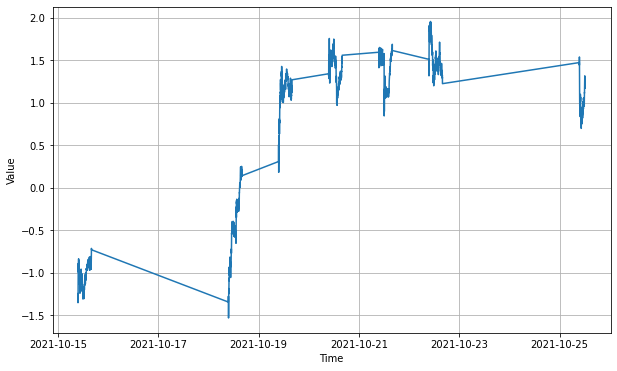

In [17]:
from sklearn.preprocessing import StandardScaler

series = one_m_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(one_m_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [18]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [20]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2000,)
Epoch 1/100
8/8 [==============================] - 4s 51ms/step - loss: 2.7564 - mae: 3.2350
Epoch 2/100
8/8 [==============================] - 1s 51ms/step - loss: 2.6714 - mae: 3.1483
Epoch 3/100
8/8 [==============================] - 1s 48ms/step - loss: 2.5370 - mae: 3.0108
Epoch 4/100
8/8 [==============================] - 1s 47ms/step - loss: 2.3745 - mae: 2.8435
Epoch 5/100
8/8 [==============================] - 1s 48ms/step - loss: 2.1935 - mae: 2.6565
Epoch 6/100
8/8 [==============================] - 1s 50ms/step - loss: 2.0071 - mae: 2.4610
Epoch 7/100
8/8 [==============================] - 1s 47ms/step - loss: 1.8299 - mae: 2.2710
Epoch 8/100
8/8 [==============================] - 1s 48ms/step - loss: 1.6810 - mae: 2.1065
Epoch 9/100
8/8 [==============================] - 1s 53ms/step - loss: 1.5654 - mae: 1.9767
Epoch 10/100
8/8 [==============================] - 1s 49ms/s

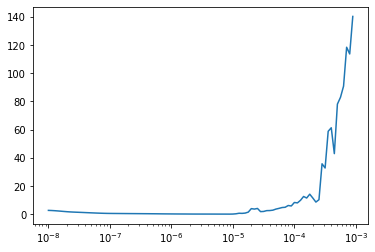

In [22]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 60])

In [23]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
20/20 [==============================] - 4s 34ms/step - loss: 0.8034 - mae: 1.1936
Epoch 2/150
20/20 [==============================] - 1s 34ms/step - loss: 1.0199 - mae: 1.4348
Epoch 3/150
20/20 [==============================] - 1s 35ms/step - loss: 1.3311 - mae: 1.7454
Epoch 4/150
20/20 [==============================] - 1s 35ms/step - loss: 0.7655 - mae: 1.1841
Epoch 5/150
20/20 [==============================] - 1s 35ms/step - loss: 0.2517 - mae: 0.6068
Epoch 6/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0704 - mae: 0.2917
Epoch 7/150
20/20 [==============================] - 1s 36ms/step - loss: 0.0336 - mae: 0.1637
Epoch 8/150
20/20 [==============================] - 1s 34ms/step - loss: 0.0267 - mae: 0.1609
Epoch 9/150
20/20 [==============================] - 1s 35ms/step - loss: 0.0193 - mae: 0.1284
Epoch 10/150
20/20 [==============================] - 1s 34ms/step - loss: 0.0168 - mae: 0.1187
Epoch 11/150
20/20 [=============================

In [24]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

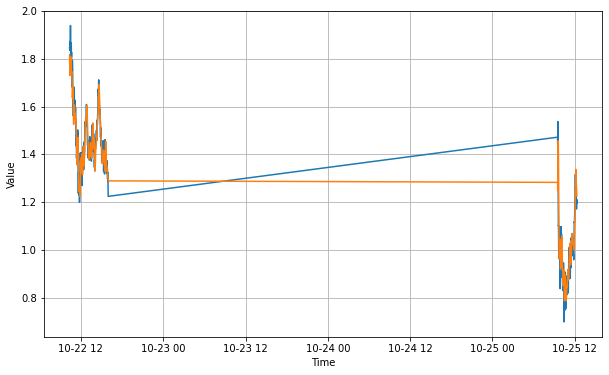

In [25]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03